In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np

# Atoms
from ase.io import read

# ML
from kernels import build_kernel, linear_kernel, gaussian_kernel, gaussian_kernel_diag, linear_kernel_diag

# Utilities
import h5py
import json
from tqdm.notebook import tqdm
from project_utils import load_structures_from_hdf5

# Plotting
import matplotlib.pyplot as plt

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# TODO: generalize for different kernels

In [3]:
# Data type for loading FPS indices
dt = np.dtype({'names': ['idxs', 'distances'], 'formats': ['i8', 'f8']})

In [4]:
# Histogram bin setup
bin_min = -4
bin_max = 1
n_bins = 101
bin_edges = np.logspace(bin_min, bin_max, n_bins)
dx = np.diff(bin_edges)

In [5]:
# Output file header for histograms
header = 'bin_edges bin_widths probability_density'

# DEEM-DEEM

In [ ]:
# Load n_Si in each structure
n_Si_deem = np.loadtxt('../Processed_Data/DEEM_10k/n_Si.dat', dtype=int)

In [ ]:
for cutoff in cutoffs:
    
    # Set data files
    idxs_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
    model_file = f'../Processed_Data/DEEM_10k/Models/{cutoff}/volumes_mae_parameters.json'
    
    # Set working directory
    work_dir = f'../Processed_Data/Histograms/{cutoff}'
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)

    # Load indices of unique environments
    deem_unique = np.loadtxt(idxs_file, dtype=dt)
    idxs = deem_unique['idxs']
    
    # Load unique SOAPs
    deem_soaps = load_structures_from_hdf5(soaps_file, datasets=None, concatenate=True)
    deem_soaps = deem_soaps[idxs, :]
    
    # Load kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
        
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Initialize histogram bins
    H = np.zeros(n_bins-1)
    DAB_min = np.zeros(len(deem_soaps))
    
    # Distance histogram diagonals
    KBB = gaussian_kernel_diag(deem_soaps, deem_soaps, gamma=gamma, k=0)
    KAA = KBB
    
    # Iteratively build KAB and the distance histogram
    for sdx, soap in enumerate(tqdm(deem_soaps)):
        
        # Compute one row of the kernel
        soap = np.reshape(soap, (1, -1)) # Add extra dimension for cdist in gaussian_kernel
        DAB = -2.0*gaussian_kernel(soap, deem_soaps, gamma=gamma)
        DAB = np.reshape(DAB, (-1)) # Remove extra dimension
        
        # Compute squared distance for that row
        DAB += KAA[sdx] + KBB
        
        # Compute minimum distance for the row, excluding self
        # (np.delete does not modify in-place)
        DAB_min[sdx] = np.sqrt(np.amin(np.delete(DAB, sdx)))
        
        # Compute distance, taking only distances above the main diagonal
        # to avoid zero self-distances and double-counting
        DAB = np.sqrt(DAB[sdx+1:])
                
        # Compute histogram
        h, _ = np.histogram(DAB, bins=bin_edges, density=False)
        
        # Increment histogram
        H += h
     
    # Normalize the histogram
    H /= dx*np.sum(H)
    
    # Compute histogram of minimum distances
    H_min, _ = np.histogram(DAB_min, bins=bin_edges, density=True)
    
    # Save
    np.savetxt(f'{work_dir}/DEEM-DEEM_histogram.dat', 
               np.column_stack((bin_edges[0:-1], dx, H)),
               header=header)
    np.savetxt(f'{work_dir}/DEEM-DEEM_min_histogram.dat', 
               np.column_stack((bin_edges[0:-1], dx, H_min)),
               header=header)

In [ ]:
plt.bar(bin_edges[0:-1], H_min, width=dx, align='edge')
plt.xscale('log')
plt.show()

In [ ]:
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

# IZA-IZA

In [6]:
# Load IZA cantons
iza_cantons = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', 
                         dtype={'names': ['structures', 'cantons'], 'formats': ['U3', 'i8']})
canton_labels = np.unique(iza_cantons['cantons'])
print(canton_labels)

[1 2 3 4]


In [7]:
# Load IZA Si atom counts
n_Si_iza = np.loadtxt('../Processed_Data/IZA_226/n_Si.dat', dtype=int)

In [8]:
# Load IZA structures to check that cantons are connected to the correct structure
iza = read('../Raw_Data/GULP/IZA_226/IZA.xyz', index=':')
ids = [i.info['Filename'][4:7] for i in iza]
print(all(ids == iza_cantons['structures']))

True


# COD-COD

# DEEM-IZA

In [19]:
for cutoff in ['6.0']: #cutoffs:
    
    # Set data files
    idxs_file_deem = f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file_deem = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
        
    idxs_file_iza = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file_iza = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
    
    model_file = f'../Processed_Data/DEEM_10k/Models/{cutoff}/volumes_mae_parameters.json'
    
    # Set working directory
    work_dir = f'../Processed_Data/Histograms/{cutoff}'
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)
     
    # Load indices of unique environments
    deem_unique = np.loadtxt(idxs_file_deem, dtype=dt)
    idxs_deem = deem_unique['idxs']
    
    iza_unique = np.loadtxt(idxs_file_iza, dtype=dt)
    idxs_iza = iza_unique['idxs']
    
    # Load unique SOAPs
    deem_soaps = load_structures_from_hdf5(soaps_file_deem, datasets=None, concatenate=True)
    deem_soaps = deem_soaps[idxs_deem, :]
    
    iza_soaps = load_structures_from_hdf5(soaps_file_iza, datasets=None, concatenate=True)
    iza_soaps = iza_soaps[idxs_iza, :]
    
    # Associate each environment with a structure index
    split_idxs = np.cumsum(n_Si_iza)
    cantons = np.zeros(iza_soaps.shape[0], dtype=int)
    for idx, i in enumerate(idxs_iza):
        struct_number = np.nonzero((split_idxs-i) > 0)[0][0]
        cantons[idx] = iza_cantons[struct_number]['cantons']
    
    # Load kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
        
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Initialize histogram bins
    H = np.zeros(n_bins-1)
    H_min_AB = np.zeros(n_bins-1)
    H_min_BA = np.zeros(n_bins-1)
    
    # Loop over cantons
    for canton in tqdm(canton_labels):
        
        # Get IZA environments in the specified canton
        canton_idxs = np.nonzero(cantons == canton)[0]
        
        # Compute kernel diagonals for each dataset
        # A = IZA
        # B = DEEM
        KAA = gaussian_kernel_diag(iza_soaps[canton_idxs], iza_soaps[canton_idxs], gamma=gamma, k=0)
        KAA = np.reshape(KAA, (-1, 1))
        KBB = gaussian_kernel_diag(deem_soaps, deem_soaps, gamma=gamma, k=0)

        # Compute kernel between datasets
        DAB = -2.0*gaussian_kernel(iza_soaps[canton_idxs], deem_soaps, gamma=gamma)

        # Compute kernel distance
        DAB += KAA + KBB 
        DAB = np.sqrt(DAB)

        # Compute minimum distance for each environment in each dataset
        # min_AB = distance from an A to the nearest B for every A
        # min_BA = distance from a B to the nearest A for every B
        DAB_min_AB = np.amin(DAB, axis=1)
        DAB_min_BA = np.amin(DAB, axis=0)

        # Compute cantonal distance histograms
        h, _ = np.histogram(DAB, bins=bin_edges, density=False)
        h_min_AB, _ = np.histogram(DAB_min_AB, bins=bin_edges, density=False)
        h_min_BA, _ = np.histogram(DAB_min_BA, bins=bin_edges, density=False)
                
        # Increment total histograms
        H += h
        H_min_AB += h_min_AB
        H_min_BA += h_min_BA
        
        # Normalize cantonal histograms 
        # (do without "/=" b/c need to promote to float)
        h = h / (dx*np.sum(h))
        h_min_AB = h_min_AB / (dx*np.sum(h_min_AB))
        h_min_BA = h_min_BA / (dx*np.sum(h_min_BA))
        
        # Save cantonal histograms
        np.savetxt(f'{work_dir}/IZA{canton}-DEEM_histogram.dat', 
                   np.column_stack((bin_edges[0:-1], dx, h)),
                   header=header)
        np.savetxt(f'{work_dir}/IZA{canton}-DEEM_min_histogram.dat', 
                   np.column_stack((bin_edges[0:-1], dx, h_min_AB)),
                   header=header)
        np.savetxt(f'{work_dir}/DEEM-IZA{canton}_min_histogram.dat',
                   np.column_stack((bin_edges[0:-1], dx, h_min_BA)),
                   header=header)
        
    # Normalize the total histograms
    H /= dx*np.sum(H)
    H_min_AB /= dx*np.sum(H_min_AB)
    H_min_BA /= dx*np.sum(H_min_BA)
    
    # Save
    np.savetxt(f'{work_dir}/IZA-DEEM_histogram.dat', 
               np.column_stack((bin_edges[0:-1], dx, H)),
               header=header)
    np.savetxt(f'{work_dir}/IZA-DEEM_min_histogram.dat', 
               np.column_stack((bin_edges[0:-1], dx, H_min_AB)),
               header=header)
    np.savetxt(f'{work_dir}/DEEM-IZA_min_histogram.dat',
               np.column_stack((bin_edges[0:-1], dx, H_min_BA)),
               header=header)

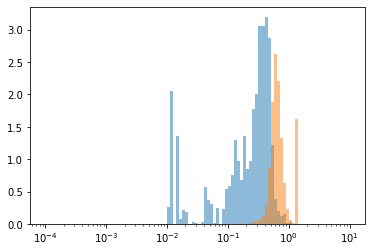

In [20]:
plt.bar(bin_edges[0:-1], H_min_AB, width=dx, align='edge', alpha=0.5)
plt.bar(bin_edges[0:-1], H_min_BA, width=dx, align='edge', alpha=0.5)
plt.xscale('log')
plt.show()

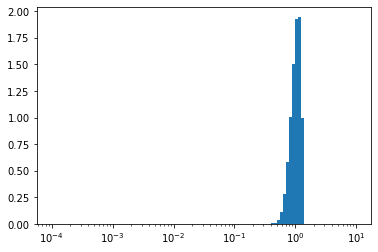

In [21]:
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

# DEEM-COD

In [ ]:
n_Si_cod = np.loadtxt('../Processed_Data/COD_196/n_Si.dat', dtype=int)

In [ ]:
for cutoff in cutoffs:
    deem_unique = np.loadtxt(f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_unique.idxs', dtype=dt)
    cod_unique = np.loadtxt(f'../Processed_Data/COD_196onDEEM_10k/{cutoff}/FPS_unique.idxs', dtype=dt)
